### Optimal parameters

<font color='red'>**Warning!**</font> The execution of the following cell takes considerable resources and time.

In [8]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from st_dbscan import ST_DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read tweets
data_dir = os.path.realpath("../data")
tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

# Remove tweets with no coordinates
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
        (tweets.latitude > 42.33278)
    &   (tweets.latitude < 51.08917)
    &   (tweets.longitude > -4.795556)
    &   (tweets.longitude < +8.230556)
]

# Order tweets by datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames'], inplace=True)
except:
    pass

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Convert tweets to geodataframe
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Project tweets to Lambert 93
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Reorder columns
tweets = tweets[['text', 'entity', 'wikidata', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [3]:
# Scale coordinates to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tweets[['x_m', 'y_m']])

# Convert datetime (in ns) to seconds, // (floor division) 10 ** 9 to get seconds
tweets['ts'] = (tweets['createdAt'].values.astype(np.int64) // 10 ** 9)
# Convert ts in tweets to cumulative seconds
tweets['ts'] -= tweets['ts'].min()

# ts, x_m_norm, y_m_norm
data = np.hstack((tweets['ts'].values.reshape(-1, 1), scaled))

In [4]:
# Create a min_dist list
min_dist = [0.01 * i for i in range(1, 11)]
# Create a min_points list
min_points = [i for i in range(24, 32)]

# Calculate max number of clusters for each min_dist and min_points combination
max_n_clusters = np.zeros((len(min_points), len(min_dist)))

for i in range(len(min_dist) ):
    md = min_dist[i]
    for j in range(len(min_points)):
        mp = min_points[j]
        # Create ST-DBSCAN object
        st_dbscan = ST_DBSCAN(eps1=md, eps2=60*10, min_samples=mp, metric='euclidean', n_jobs=-1).fit(data)
        # Get number of clusters
        n_clusters = st_dbscan.labels.max() + 2
        # Store number of clusters
        max_n_clusters[j, i] = n_clusters

# Add min_dist and min_points to max_n_clusters
max_n_clusters = np.hstack((np.array(min_points).reshape(-1, 1), max_n_clusters))
max_n_clusters = np.vstack((np.array([0] + min_dist).reshape(1, -1), max_n_clusters))

# Create a dataframe from max_n_clusters
max_n_clusters = pd.DataFrame(max_n_clusters, columns=['min_points'] + [f'max_dist={i}' for i in min_dist])

# Set min_points as index
max_n_clusters.set_index('min_points', inplace=True)

# Remove first row
max_n_clusters = max_n_clusters.iloc[1:, :]

In [5]:
# Save to csv
max_n_clusters.to_csv(os.path.join(data_dir, "max_n_clusters.csv"))
max_n_clusters

,max_dist=0.01,max_dist=0.02,max_dist=0.03,max_dist=0.04,max_dist=0.05,max_dist=0.06,max_dist=0.07,max_dist=0.08,max_dist=0.09,max_dist=0.1
min_points,,,,,,,,,,
24.0,25.0,20.0,18.0,12.0,12.0,9.0,8.0,8.0,8.0,8.0
25.0,21.0,20.0,16.0,12.0,10.0,8.0,7.0,7.0,7.0,7.0
26.0,20.0,20.0,15.0,11.0,10.0,9.0,8.0,7.0,7.0,7.0
27.0,18.0,17.0,17.0,12.0,11.0,11.0,9.0,9.0,9.0,9.0
28.0,19.0,18.0,20.0,14.0,10.0,10.0,8.0,8.0,8.0,8.0
29.0,17.0,16.0,21.0,15.0,9.0,10.0,8.0,8.0,8.0,8.0
30.0,14.0,12.0,21.0,16.0,8.0,10.0,8.0,7.0,7.0,7.0
31.0,14.0,12.0,20.0,15.0,8.0,8.0,6.0,6.0,6.0,6.0


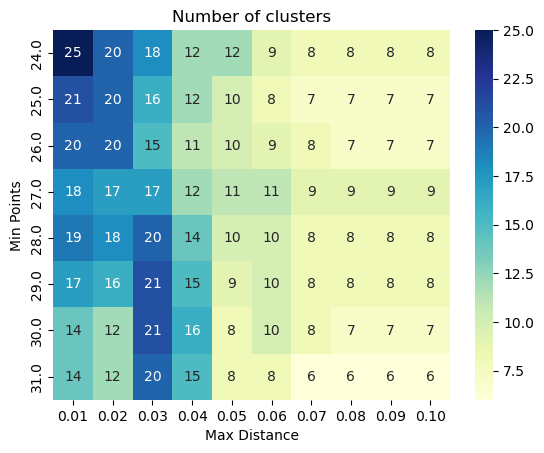

In [9]:
# Plot max_n_clusters
import seaborn as sns
fig, ax_cluster = plt.subplots()
ax_cluster = sns.heatmap(max_n_clusters, annot=True, fmt=".0f", cmap="YlGnBu", ax=ax_cluster)
ax_cluster.set_title("Number of clusters")
ax_cluster.set_xlabel("Max Distance")
ax_cluster.set_ylabel("Min Points")

# Set xlabel values
ax_cluster.set_xticklabels([f"{i:.2f}" for i in min_dist], rotation=0)

plt.show()